In [227]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
import sys
sys.path.append('../../..')

In [229]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.prop.Transformations import MagneticField, MagneticField2Magnetisation
from magrec.misc.data import Data
from magrec import __datapath__

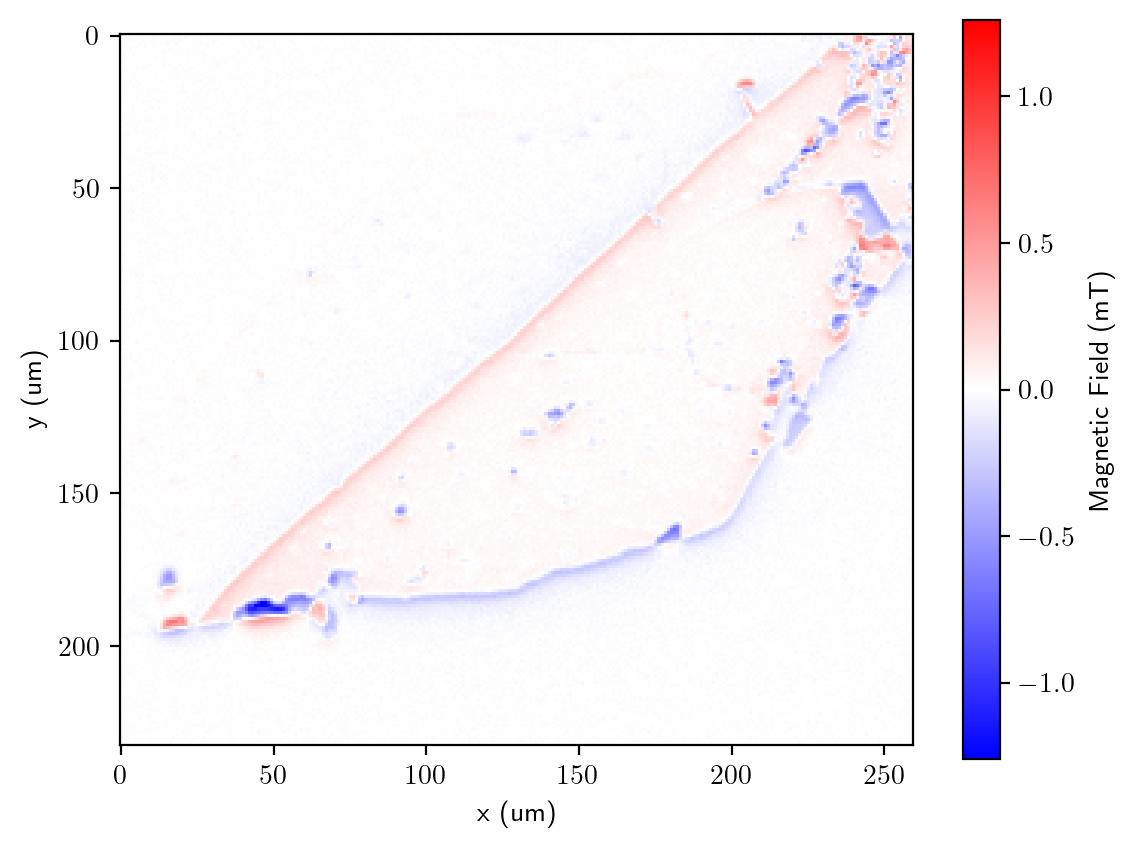

In [230]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

# dataset.define_pixel_size(dx, dy)

sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 90 

dataset = Data()
dataset.load_data(BNV, dx, dy, 0.05, sensor_theta, sensor_phi, 0)

dataset.remove_DC_background()
dataset.plot_target()


In [231]:
# Add filter 
dataset.add_hanning_filter(0.05)
dataset.add_hanning_filter(0.05)

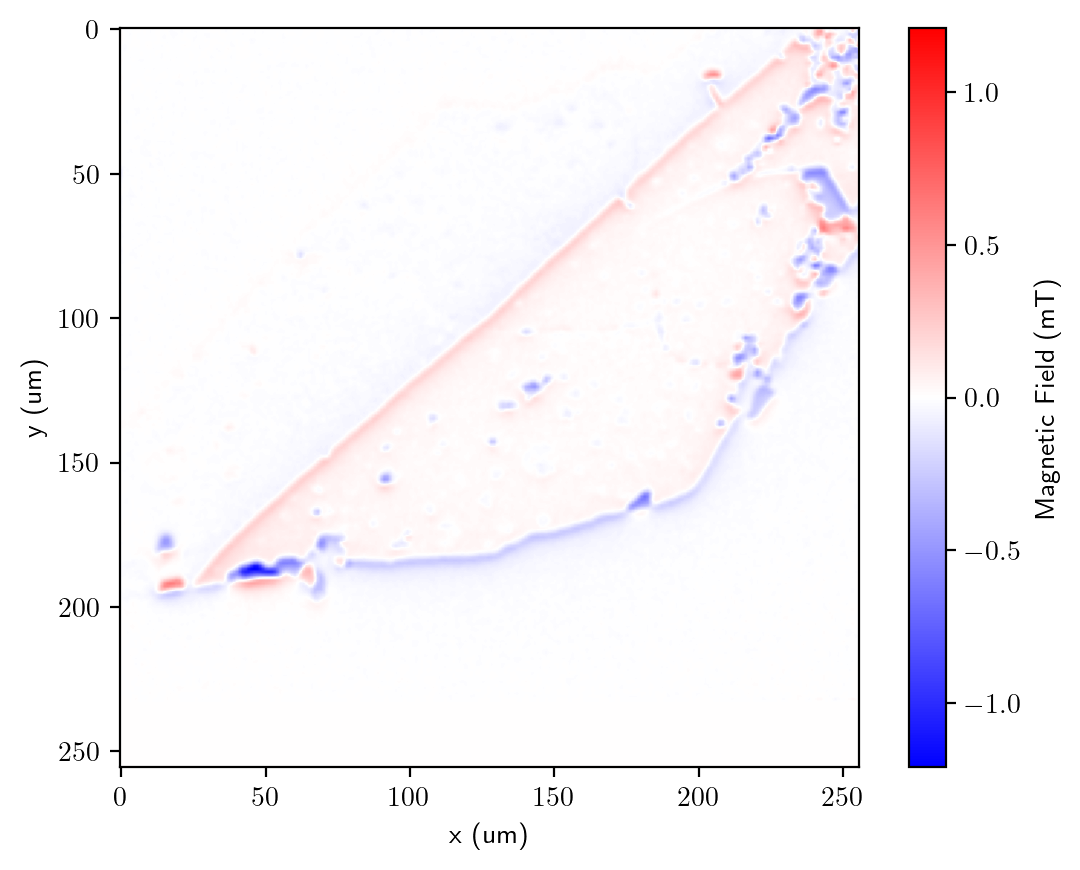

In [232]:
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()

In [233]:
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.05
3,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.05
4,crop_data,False,crop_data,crop the data with the given region of interest,"roi = [0,256,0,256,]"
5,pad_data,True,crop_data,Padded the data to a square image with dimensi...,None


# Transfor Bsensor into Bxyz

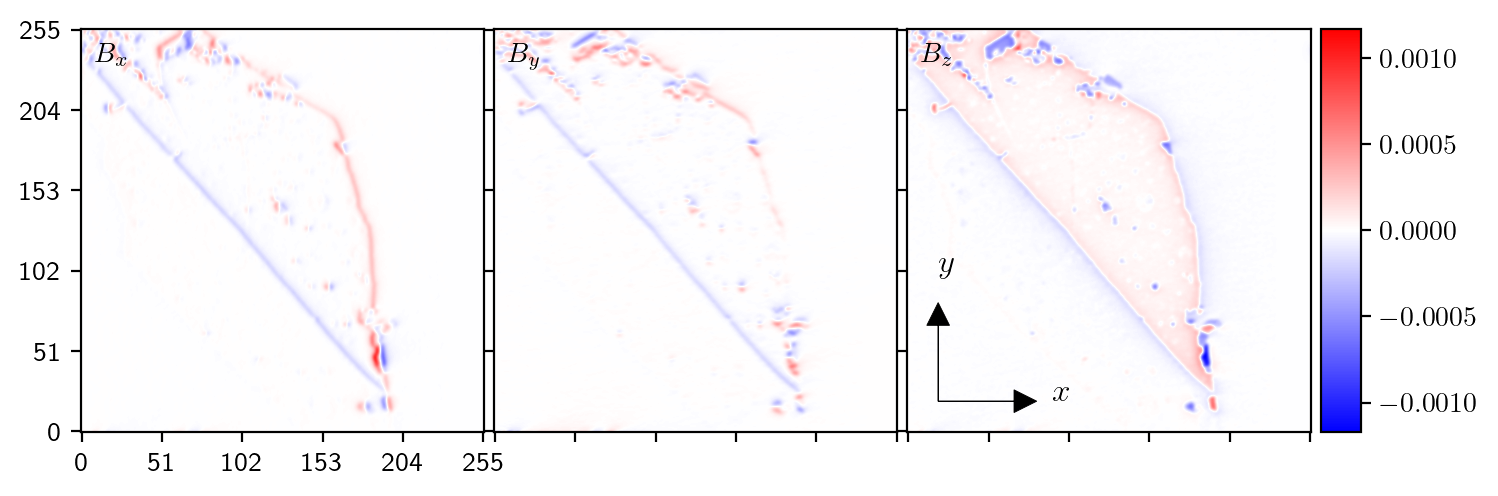

In [234]:
dataset.set_transformer(MagneticField)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

## Reconstruct the out of plane magnetisation using the B sensor

In [235]:
dataset2 = copy.deepcopy(dataset)

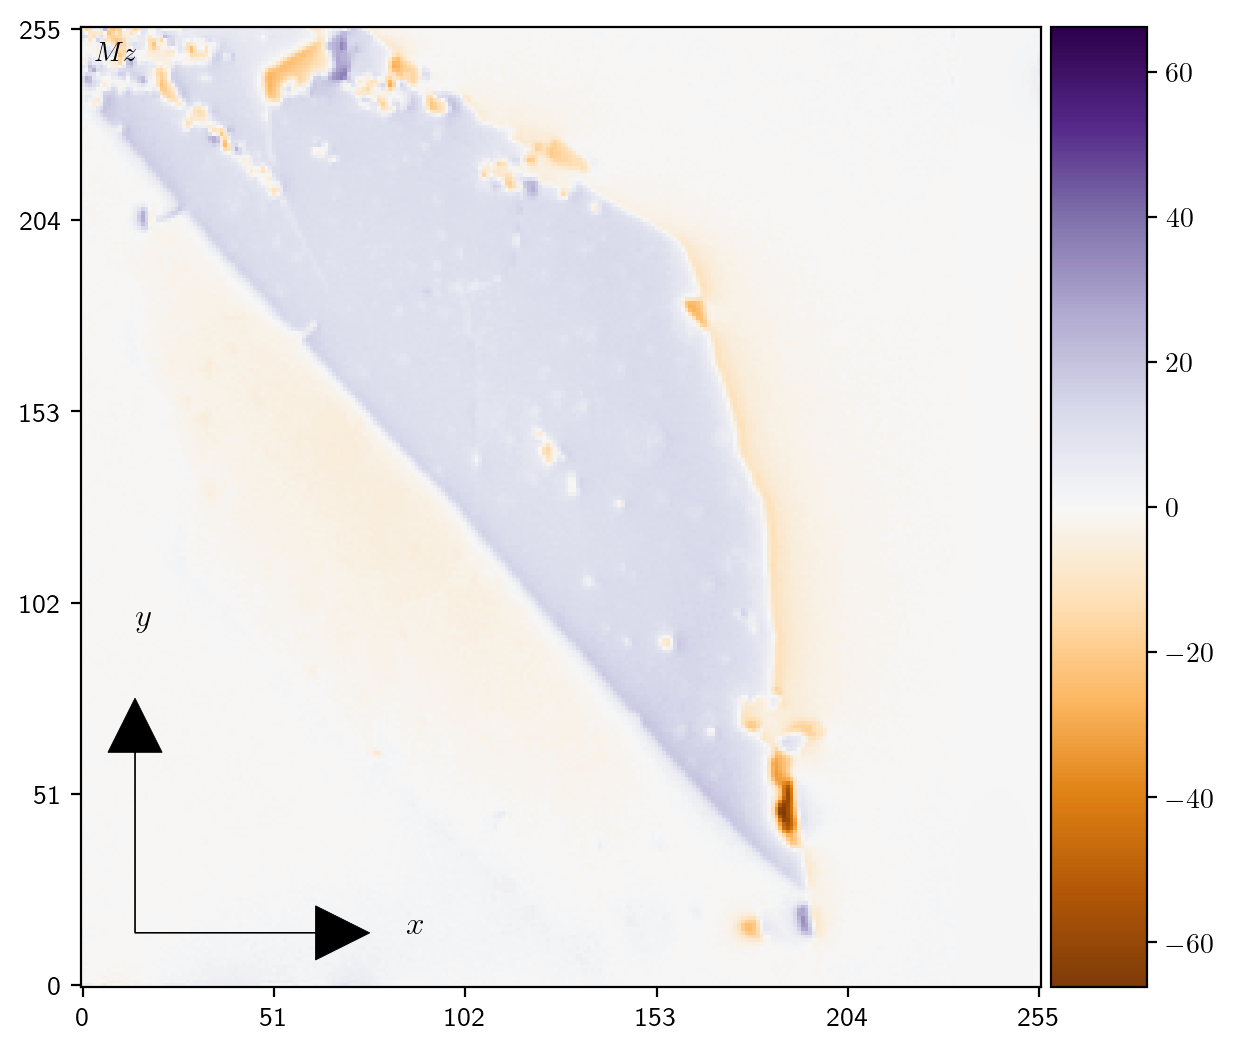

In [236]:
dataset2.set_transformer(MagneticField2Magnetisation, m_theta = 0, m_phi = 0)
dataset2.transform_data()

plot_n_components(
    -1*dataset2.transformed_target + 2, 
    symmetric=True, 
    labels=[r"$Mz$"], 
    cmap="PuOr")

## Reconstruct using only the Bz magnetic field component

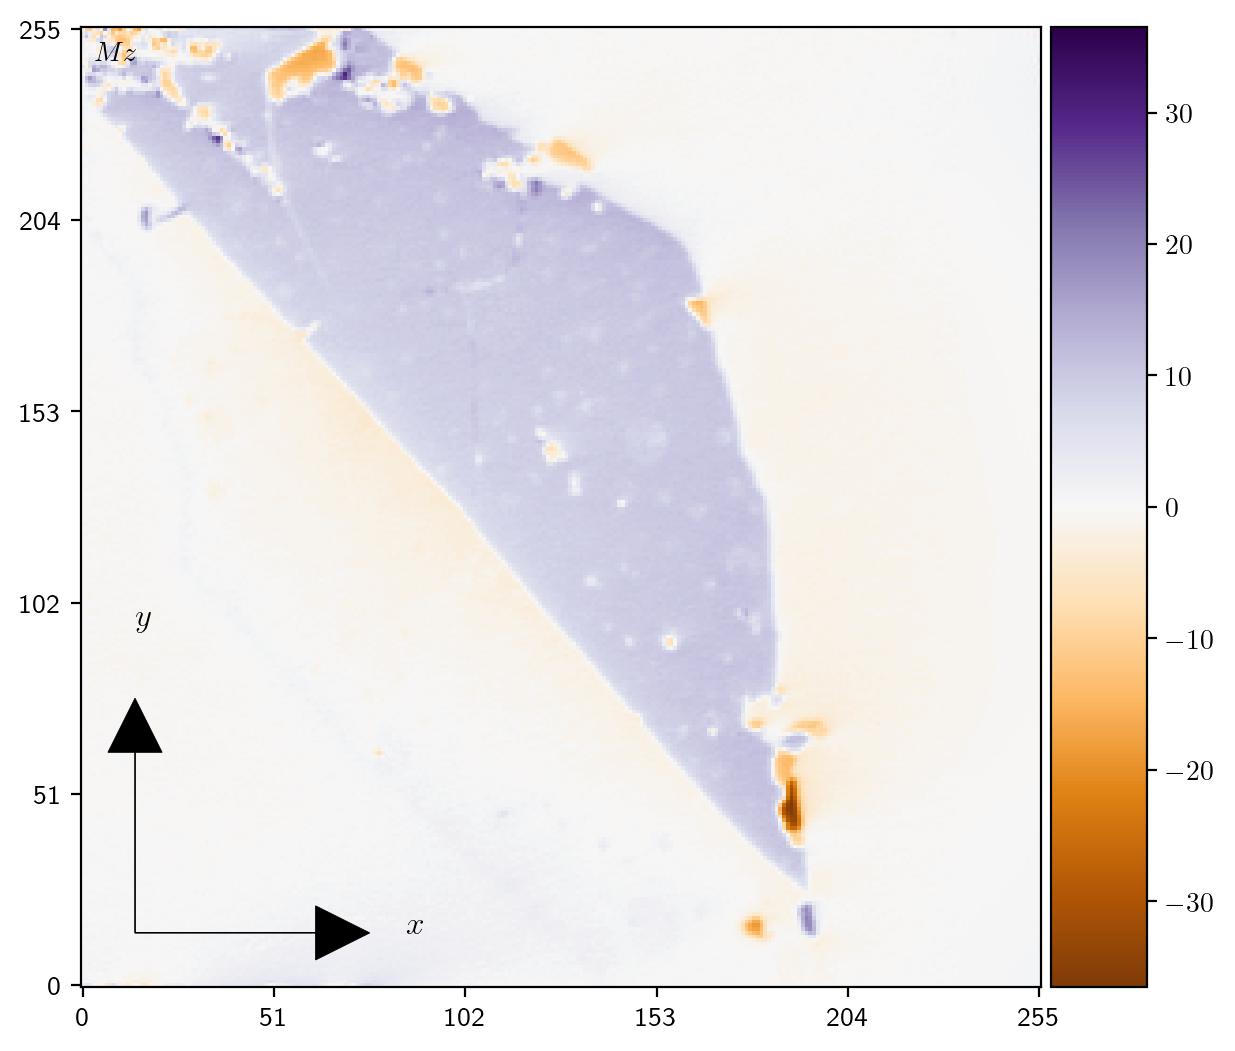

In [237]:
dataset3 = copy.deepcopy(dataset)
dataset3.target = dataset.transformed_target[2,::]
dataset3.define_sensor_angles(0, 0)
dataset3.set_transformer(MagneticField2Magnetisation, m_theta = 0, m_phi = 0)
dataset3.transform_data()

plot_n_components(
    -1*dataset3.transformed_target + 2, 
    symmetric=True, 
    labels=[r"$Mz$"], 
    cmap="PuOr")

## Now we will try to reconstruct the magnetisation using a neural network.

To begin with let's just test that we can acutally transform a magnetisation to a B-field correctly

In [238]:
from magrec.prop.Transformations import Magnetisation2MagneticField as M2B

dataset3.define_sensor_angles(0, 0)
dataset3.define_height(0.05)

magClass = M2B(dataset3, m_theta = 0, m_phi = 0)

btest = magClass.transform(dataset3.transformed_target)


<Figure size 640x480 with 0 Axes>

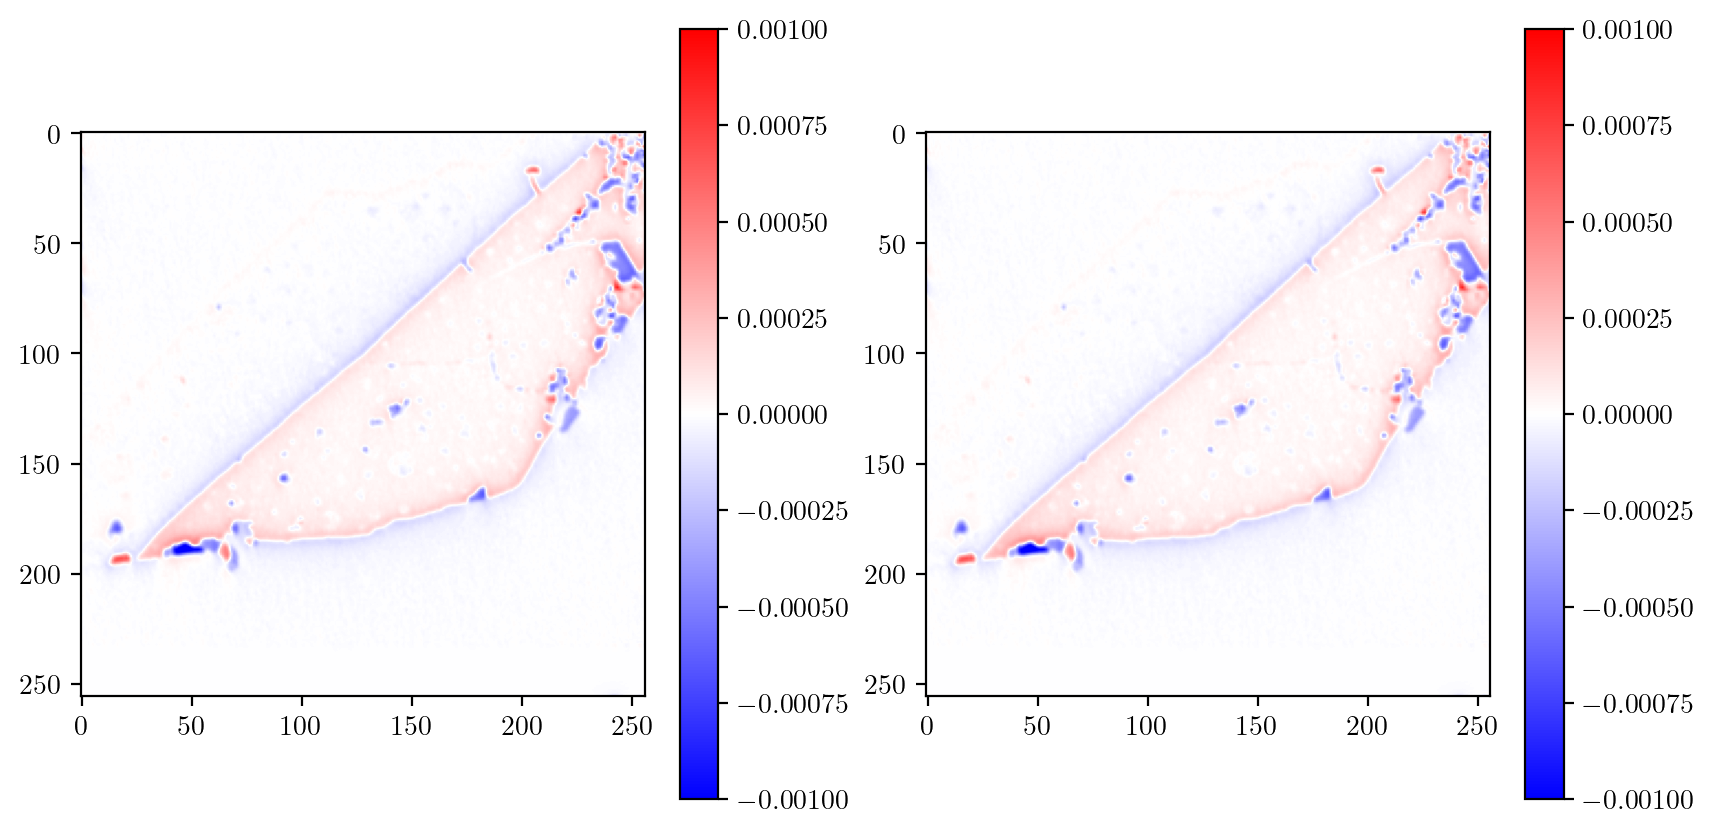

In [254]:
plt.figure()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(dataset3.target, cmap="bwr", vmin=-0.001, vmax=0.001)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(btest, cmap="bwr", vmin=-0.001, vmax=0.001)
plt.colorbar()

In [250]:
from magrec.method.CNN import CNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

Model = UniformMagnetisation(dataset3, "L1", m_theta = 0, m_phi = 0)
FittingMethod = CNN(Model, dataset3)
FittingMethod.prepare_fit()

Number of sources: 1
Number of targets: 1


In [251]:
FittingMethod.fit(n_epochs=50)

epoch     1 | loss on last mini-batch:  2.01e-01
epoch    11 | loss on last mini-batch:  1.59e-02
epoch    21 | loss on last mini-batch:  8.11e-03
epoch    31 | loss on last mini-batch:  4.59e-03
epoch    41 | loss on last mini-batch:  3.44e-03


(tensor([[[[ 0.1261,  0.1343,  0.0979,  ...,  0.0439,  0.1263,  0.2339],
           [ 0.0128,  0.0375,  0.0868,  ...,  0.0819,  0.1710,  0.1398],
           [ 0.0483,  0.0221, -0.0131,  ...,  0.0464,  0.0292,  0.1335],
           ...,
           [-0.1210, -0.0510, -0.0154,  ...,  0.0146,  0.1459,  0.1927],
           [-0.0078,  0.0182, -0.0360,  ...,  0.1350,  0.0988,  0.1753],
           [ 0.0085, -0.0627,  0.0115,  ...,  0.0754,  0.1382,  0.1733]]]],
        grad_fn=<ConvolutionBackward0>),
 [0.2005186676979065,
  0.17902670800685883,
  0.0981932133436203,
  0.0731218010187149,
  0.06013699620962143,
  0.048802997916936874,
  0.038771241903305054,
  0.030965203419327736,
  0.025006003677845,
  0.020058762282133102,
  0.015937509015202522,
  0.012909432873129845,
  0.011115653440356255,
  0.010256491601467133,
  0.00992533378303051,
  0.009803645312786102,
  0.009716294705867767,
  0.009561395272612572,
  0.009264820255339146,
  0.008779572322964668,
  0.008107148110866547,
  0.007317

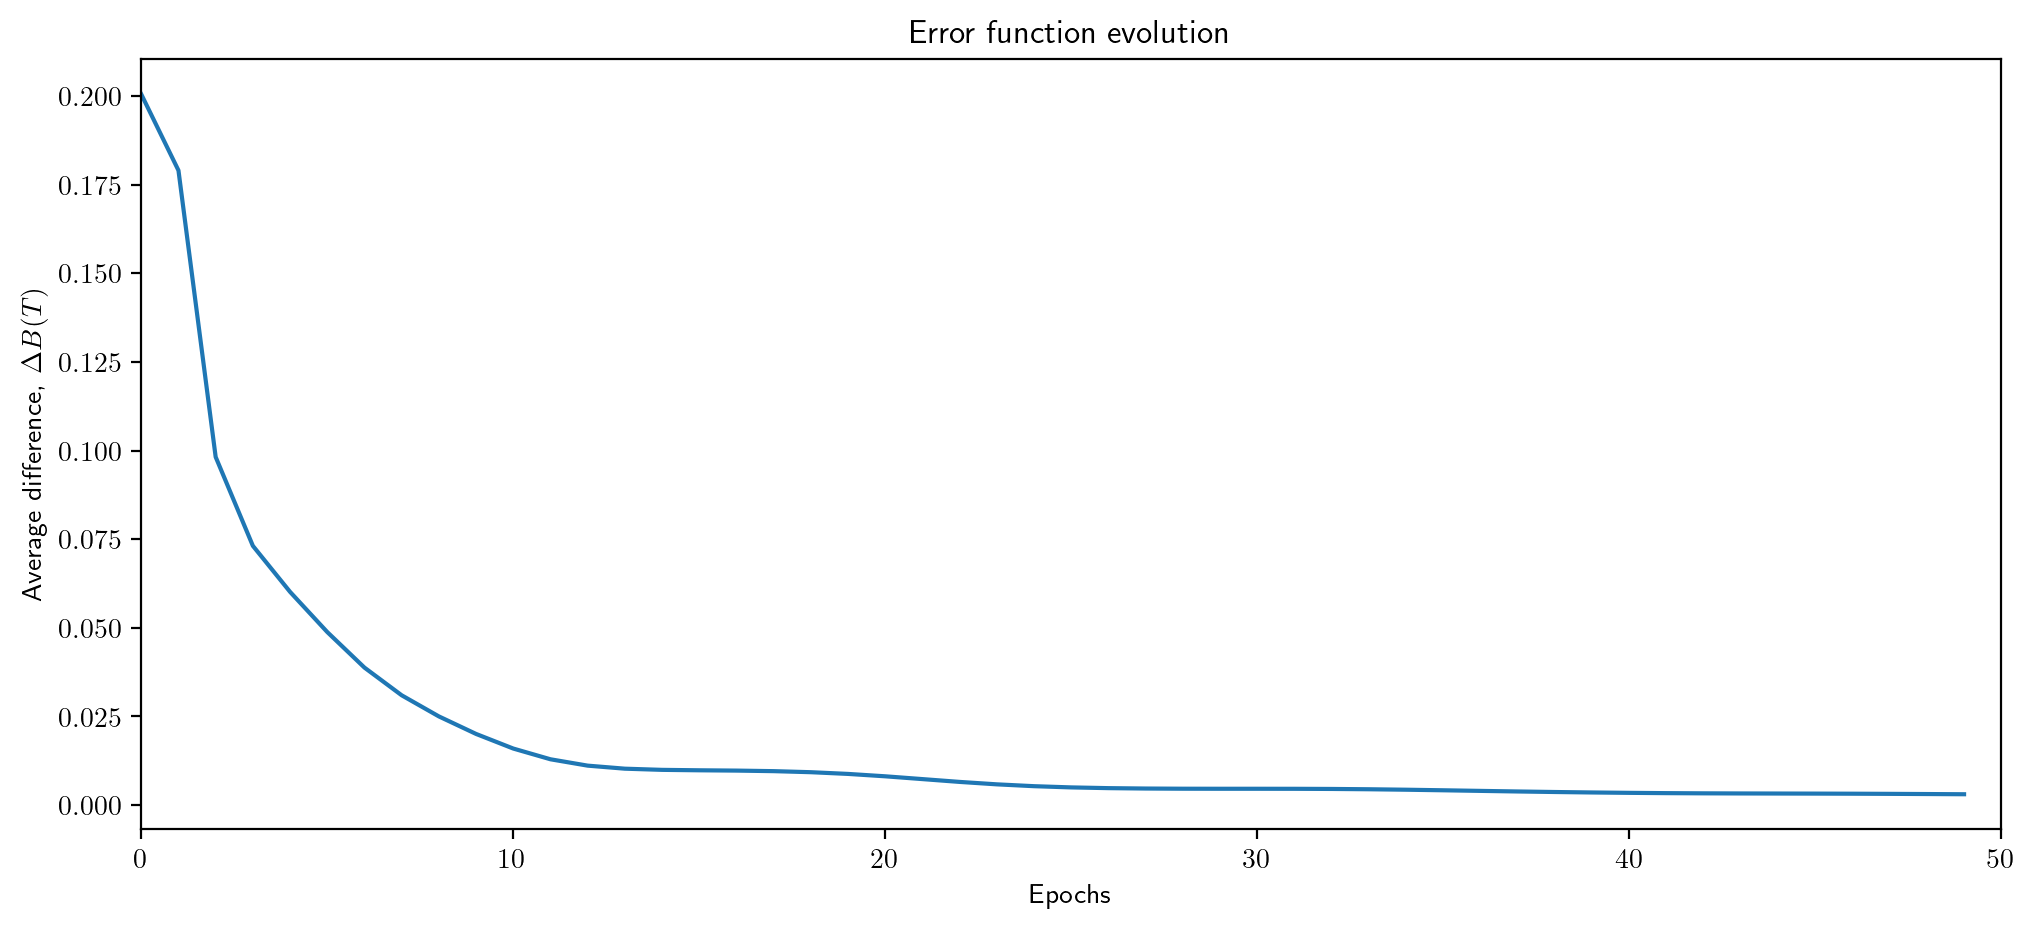

In [252]:
FittingMethod.plot_loss()

<Figure size 640x480 with 0 Axes>

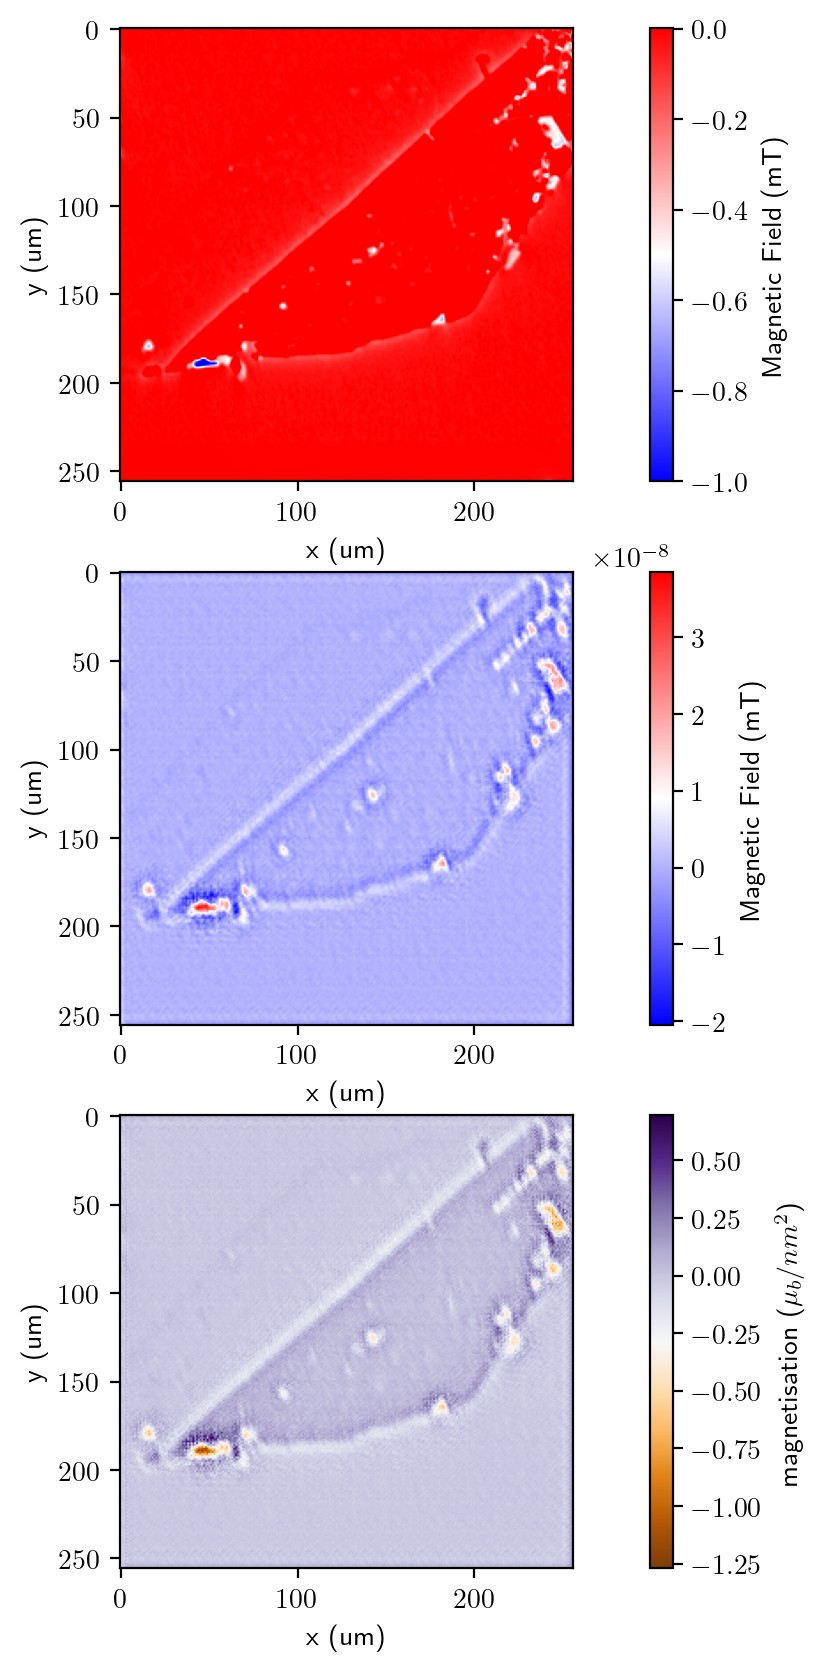

In [256]:
plt.figure()
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.imshow(dataset3.target*1e3, cmap="bwr")
cb = plt.colorbar()
plt.xlabel("x (um)")
plt.ylabel("y (um)")
cb.set_label("Magnetic Field (mT)")

plt.subplot(3,1,2)
plt.imshow(FittingMethod.final_b*1e-3, cmap="bwr")
cb = plt.colorbar()
plt.xlabel("x (um)")
plt.ylabel("y (um)")
cb.set_label("Magnetic Field (mT)")

plt.subplot(3,1,3)
plt.imshow(FittingMethod.final_output, cmap="PuOr")
cb = plt.colorbar()
plt.xlabel("x (um)")
plt.ylabel("y (um)")
cb.set_label("magnetisation ($\mu_b/nm^2$)")

In [244]:
FittingMethod.normalisation

tensor(0.0009)